# Experiment with Modeling of COVID-19 Spreading

Если запускаете не в colab, пожалуйста закментируйте следующую ячейку. Ячейка нужна для установки нужных `latex` пакетов, так-как они нужны при постройке графиков далее. Также следующая ячейка обновляет `statsmodels` до последней версии.

In [1]:
!pip install -U statsmodels

!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Ноутбук с экспериментом по аппроксимации модели расспроситронения коронавирусной инфекции.

In [2]:
import json
import requests
from datetime import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid

In [3]:
plt.rcParams["font.family"] = 'DejaVu Sans'

plt.rcParams['text.usetex'] = True

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

Визуализация моделей показана на [сайте.](http://3.80.183.71)

In [4]:
ip = '3.80.183.71'

Статистику по коронавирусной инфекции для Российской Федерации можно выгрузить с [сайта](http://3.80.183.71) по простому `json` [запросу](http://3.80.183.71/json/RU-MOW) (информация обновляема).

P.S. Данные основаны на информации официального сайта [стопкоронавирус.рф](https://стопкоронавирус.рф). На сайте доступные данные за последний месяц по `json` [запросу](https://стопкоронавирус.рф/covid_data.json?do=region_stats&code=RU-MOW) для произвольного региона в РФ. 

P.P.S. Информация о доступных данных для каждого региона представлена по [запросу](http://3.80.183.71/stats).

P.P.P.S. Для улучшения визуализации рекомендуется использовать браузер firefox (данный браузер имеет встроенную функцию отображения json формата в удобном для человека формате)

# Эксперимент по работе с моделью Юрия Евгеньевича Нестерова

В качестве данных рассмаривается статистика о расспространии по Москве.

## Модель без аппроксимации $\gamma$

Напомним саму модель:
- $H(d)$ - число носителей вируса без симптомов по состоянию на начало дня $d$.
- $I(d)$ - число заболевших за день $d$.
- $T(d)$ - число всех обнаруженых случаем на конец $d$-го дня.
- $C(d)$ - число новых случаем за $d$-й день представленных в СМИ.

В модели вводятся следующие ограничения:
- Все выяленные пациенты изолированы и никого не заражают.
- Все пациенты которые не обнаружены к началу $d$-го дня равномерно заражают всех людей с некоторым параметром интенсивности $\gamma(d)$ зависящим от дня.
- Все зараженные пациенты болеют вирусом без симптомов в течении $\Delta$ дней.

Функции связи на основе введенных ограничений:
- $I(d) = \gamma(d)H(d)$
- $T(d) = T(d-1) + C(d)$
- $C(d) = I(d-\Delta)$

На основе предложенных функций связи получаем следующие формулы:
- $T(d+1) = T(d) + \gamma(d-\Delta+1)(T(d) - T(d-\Delta))$.
- $\gamma(d) = \frac{I(d)}{H(d)} = \frac{C(d+\Delta)}{T(d+\Delta-1) - T(d-1)}$

Введем агрегирующий параметр $\Gamma(d)$ который характеризирует сколько в среднем один человек заражает людей за период пока вирус не обнаружен
$$
\Gamma(d) = \sum_{i=0}^{\Delta-1}\gamma(d+i)
$$

In [5]:
data = requests.get('http://{}/json/RU-MOW'.format(ip)).json()['real']

In [6]:
dataframe = pd.DataFrame(data).T

Рассмотрим полученные данные

In [7]:
dataframe.sample(5)

,date,died,sick,recovered
135,25.07.2020,14,648,561
60,11.05.2020,56,6169,4032
90,10.06.2020,56,1195,3796
227,25.10.2020,68,4455,2614
104,24.06.2020,14,811,2020


В данной таблице нас интересует столбец `sick` которая показывает число новых заболеваний опубликованых в СМИ по состоянию на $d$-й день. Данный столбец соответсвует $C(d)$ в наших обозначениях.

Построем новый словарь данных:
- поле `new sick` соответсвует $C(d)$
- поле `sick` соответсвует $T(d)$
- поле `delta` соответсвует $\Delta$
- поле `gamma` соответсвует $\gamma(d)$

In [8]:
delta = 14
gamma = 1/delta

In [9]:
dict_of_data = dict()

# поле "new sick" соответствует C(d)
for key in data:
    date = datetime.strptime(data[key]['date'], '%d.%m.%Y').date()
    if date not in dict_of_data:
        dict_of_data[date] = dict()
    dict_of_data[date]['new sick'] = data[key]['sick']
    
# поле "sick" соответствует T(d)
for key in dict_of_data:
    dict_of_data[key]['sick'] = dict_of_data.get(key - timedelta(days=1), {'sick': 0})['sick'] \
                                + dict_of_data[key]['new sick'] 

# поле "gamma" соответствует \gamma(d)
# поле "delta" соответствует \Delta
for key in dict_of_data:
    dict_of_data[key]['delta'] = delta
    # если данных достаочно, то считаем \gamma(d) = C(d+\Delta)/(T(d+\Delta-1) - T(d-1))
    # если данные уже не доступны для прогноза, то \gamma  не определен (для послежних \Delta дней) 
    try:
        dict_of_data[key]['gamma'] = dict_of_data[key + timedelta(days=dict_of_data[key]['delta'])]['new sick']\
                                     /(dict_of_data[key+ timedelta(days=dict_of_data[key]['delta']-1)]['sick'] \
                                       - dict_of_data.get(key+ timedelta(days=-1), {'sick': 0})['sick'])
    except:
        # для последних 14 дней устанавливаем некоторые стандарное значение, в нашем случае 1/\Delta
        continue

In [10]:
last_available = list(dict_of_data.keys())[-1]

In [11]:
pd.DataFrame(dict_of_data).T

,new sick,sick,delta,gamma
2020-03-12,21.0,21.0,14.0,0.331707
2020-03-13,5.0,26.0,14.0,0.299048
2020-03-14,9.0,35.0,14.0,0.168390
2020-03-15,0.0,35.0,14.0,0.251918
2020-03-16,18.0,53.0,14.0,0.216547
...,...,...,...,...
2020-11-11,4477.0,485545.0,14.0,NaN
2020-11-12,5997.0,491542.0,14.0,NaN
2020-11-13,5974.0,497516.0,14.0,NaN
2020-11-14,6427.0,503943.0,14.0,NaN


In [12]:
def get_Gamma(dict_of_data, key, delta):
    summ = 0
    
    for i in range(0, delta):
        summ += dict_of_data.get(key + timedelta(days=i), {'gamma': 0}).get('gamma', gamma)
        
    return summ

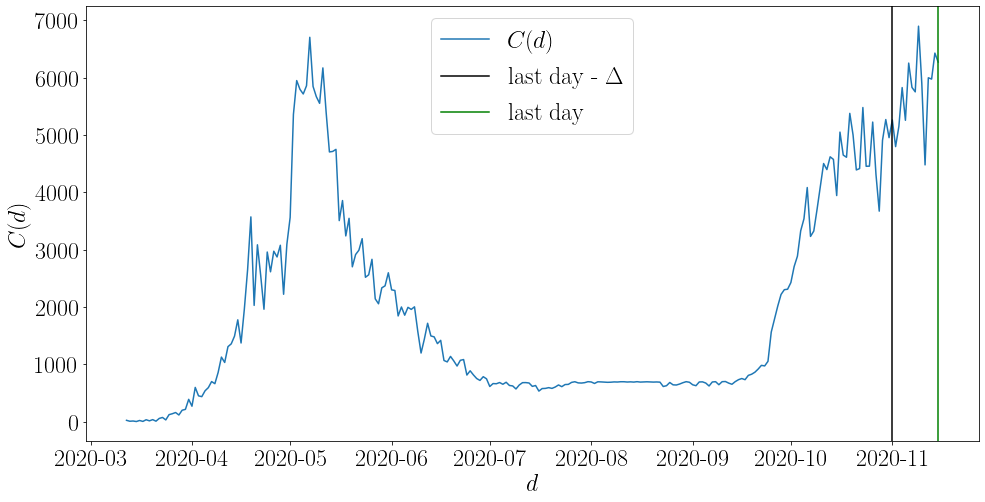

In [13]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [dict_of_data[key].get('new sick', 0) for key in dict_of_data], label = '$C(d)$')

plt.axvline(last_available + timedelta(days=-delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$C(d)$')
plt.show()

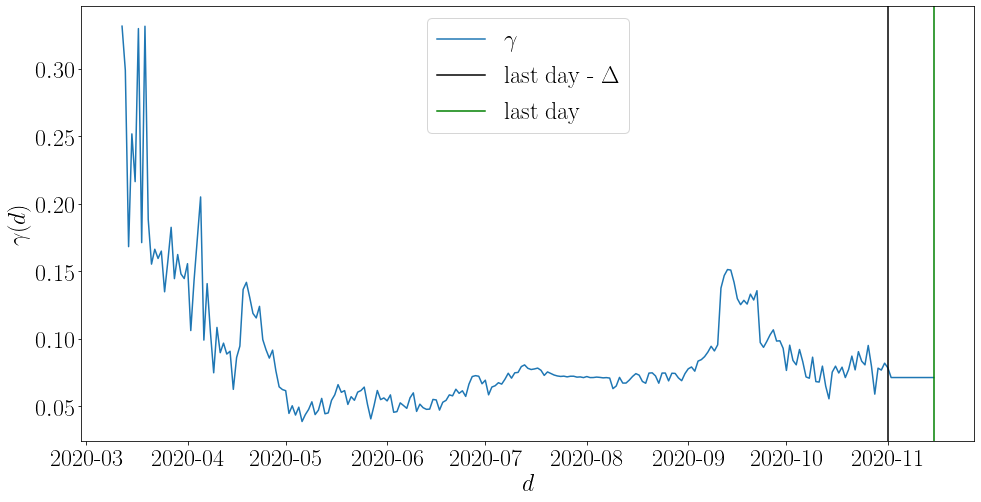

In [14]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [dict_of_data[key].get('gamma', gamma) for key in dict_of_data], label = '$\gamma$')

plt.axvline(last_available + timedelta(days=-delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\gamma(d)$')
plt.show()

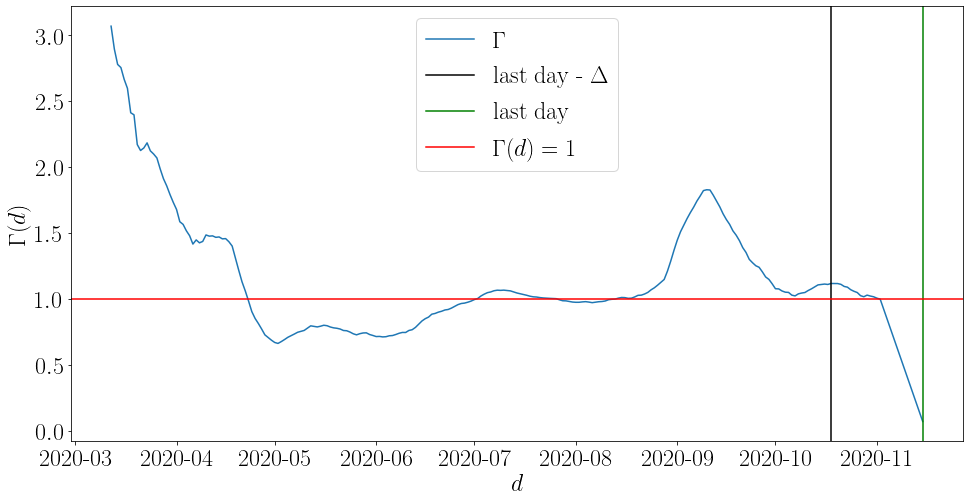

In [15]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [get_Gamma(dict_of_data, key, delta) for key in dict_of_data], label = '$\Gamma$')

plt.axvline(last_available + timedelta(days=-2*delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')
plt.axhline(1, color='red', label = '$\Gamma(d) = 1$')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\Gamma(d)$')
plt.show()

Из графиков приведенных выше видно, что для Москвы пик зараженности наблюдался в средине сентября, причем в октябре зараженность упала. То есть среднее число людей которое инфицирует один человек падает начиная с октября месяца. Правда на текущий момент можно говорить только про период до средины октября, так как для построения графика $\Gamma(d)$ нужна информация о $d + 2\Delta$ дне.

## Модель с аппроксимацией параметра $\gamma$

В рамках данной модели нельзя строить график для текущего дня. Предлагается использовать методы машинного обучения для предсказания параметра $\gamma$.

In [16]:
gammas = [dict_of_data[key]['gamma'] for key in dict_of_data if 'gamma' in dict_of_data[key]]
dates = [key.strftime('%Y-%m-%d') for key in dict_of_data if 'gamma' in dict_of_data[key]]
gamma_model = ARIMA(pd.Series(gammas, index=dates), order=(6, 0, 4), trend='n').fit()

/Library/Python/3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Python/3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Python/3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Python/3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [17]:
for key in dict_of_data:
    if 'gamma' not in dict_of_data[key]:
        cur_date = key.strftime('%Y-%m-%d')
        dict_of_data[key]['gamma'] = gamma_model.predict(start=cur_date, end=cur_date).values[0]
        

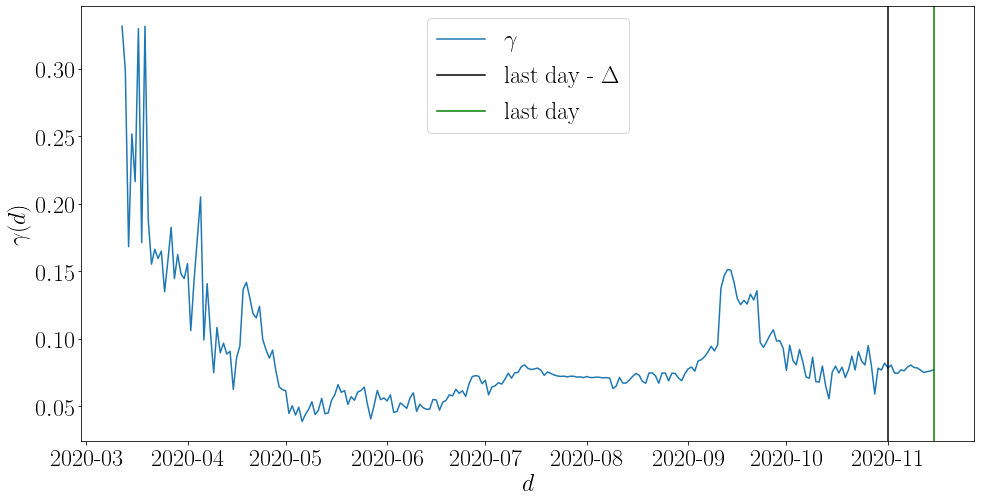

In [18]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [dict_of_data[key].get('gamma', gamma) for key in dict_of_data], label = '$\gamma$')

plt.axvline(last_available + timedelta(days=-delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\gamma(d)$')
plt.show()

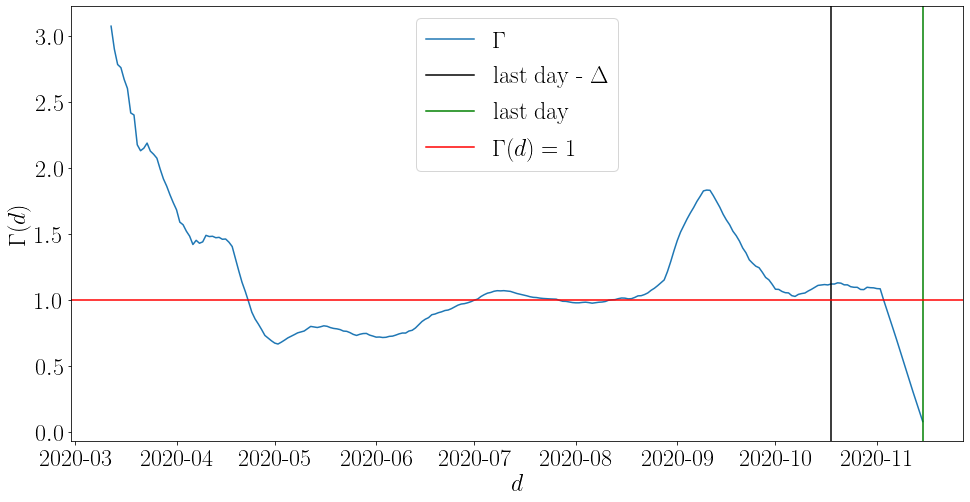

In [19]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [get_Gamma(dict_of_data, key, delta) for key in dict_of_data], label = '$\Gamma$')

plt.axvline(last_available + timedelta(days=-2*delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')
plt.axhline(1, color='red', label = '$\Gamma(d) = 1$')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\Gamma(d)$')
plt.show()

Сейчас мы экстраполировали параметр $\gamma(d)$ до сегодняшнего дня `last day` на основе информации, которая доступна по $\gamma(d)$ до дня, для которого это значение считается `last day` - $\Delta$.

Так как информации о $\gamma(d)$ не известна для всех дней $d>$`last day` кривая $\Gamma$ после дня `last day` - $\Delta$ убывает (так как мы не знаем сколько человек в среднем заражает за следующие $\Delta$ дней, так как информация не известна).

Попытаемся экстраполировать данные о числе заболевших на $\Delta$ дней вперед.

In [20]:
extrapolate_to = last_available + timedelta(days=delta)

In [21]:
cur_date = last_available + timedelta(days=1)
while cur_date <= extrapolate_to:
    dict_of_data[cur_date] = dict()
    dict_of_data[cur_date]['delta'] = delta

    dict_of_data[cur_date]['gamma'] = \
        gamma_model.predict(start=cur_date.strftime('%Y-%m-%d'),
                             end=cur_date.strftime('%Y-%m-%d')).values[0]
        
    dict_of_data[cur_date]['new sick'] = int(
        dict_of_data.get(
            cur_date - timedelta(days=dict_of_data[cur_date]['delta']),
            {'gamma': gamma})['gamma'] \
        * (dict_of_data.get(cur_date - timedelta(days=1),
                                 {'sick': 0})['sick'] \
           - dict_of_data.get(
            cur_date - timedelta(days=dict_of_data[cur_date]['delta'] + 1),
            {'sick': 0})['sick']))
    
    dict_of_data[cur_date]['sick'] = dict_of_data.get(
        cur_date - timedelta(days=1),
        {'sick': 0})['sick'] + dict_of_data[cur_date]['new sick']
        
    cur_date = cur_date + timedelta(days=1)

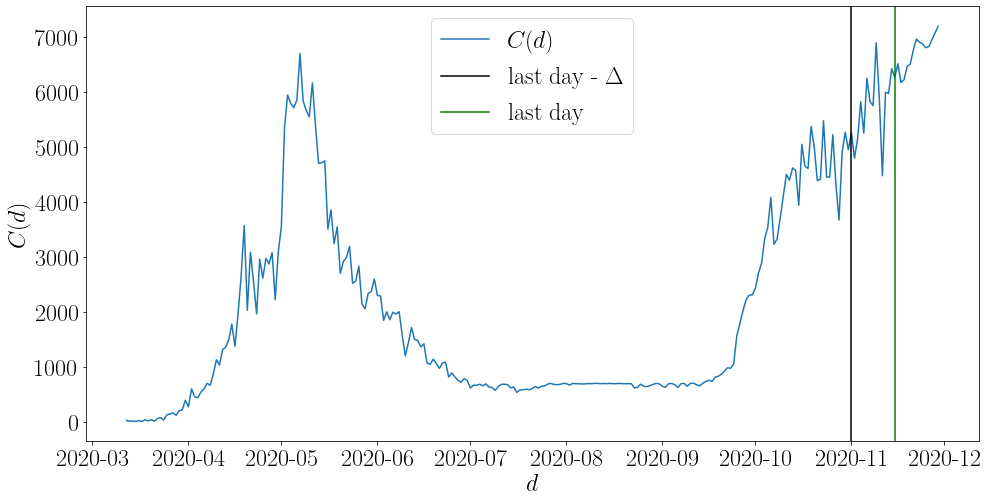

In [22]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [dict_of_data[key].get('new sick', 0) for key in dict_of_data], label = '$C(d)$')

plt.axvline(last_available + timedelta(days=-delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$C(d)$')
plt.show()

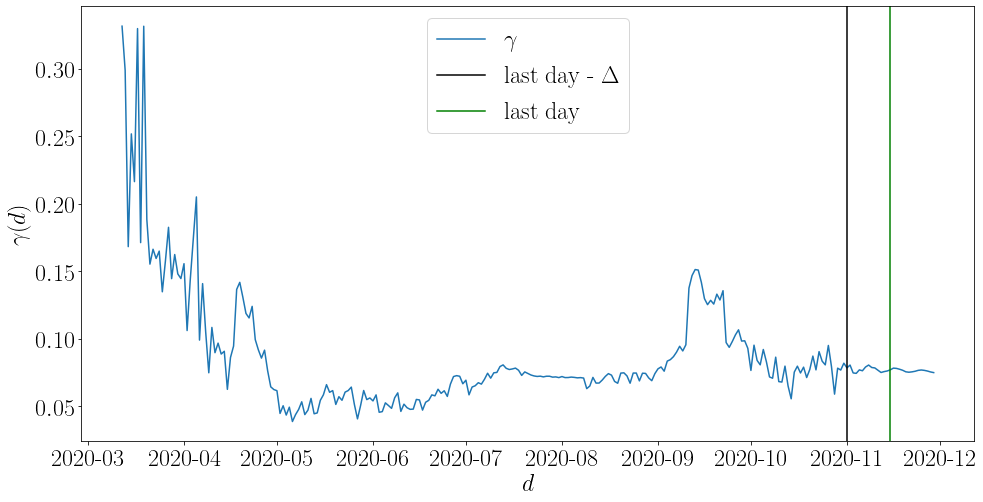

In [23]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [dict_of_data[key].get('gamma', gamma) for key in dict_of_data], label = '$\gamma$')

plt.axvline(last_available + timedelta(days=-delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\gamma(d)$')
plt.show()

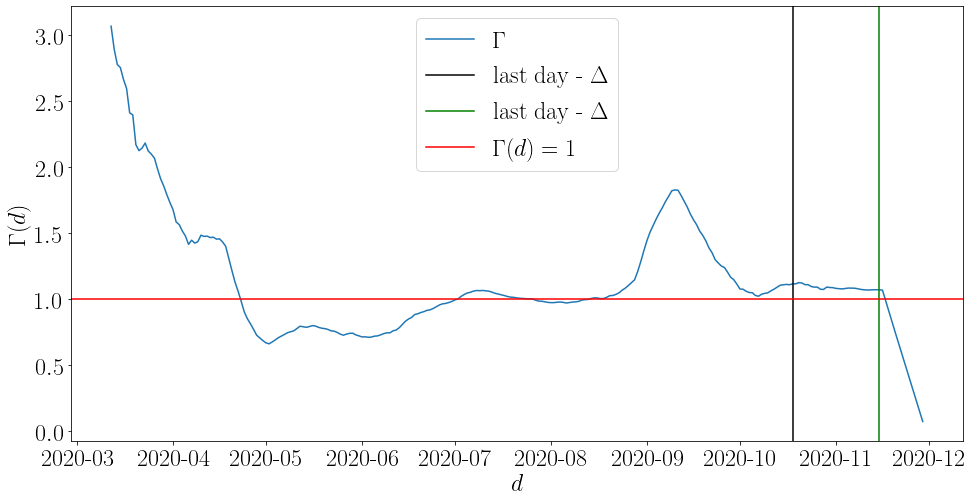

In [24]:
fig = plt.figure(figsize = (16, 8))
plt.plot(list(dict_of_data.keys()), [get_Gamma(dict_of_data, key, delta) for key in dict_of_data], label = '$\Gamma$')

plt.axvline(last_available + timedelta(days=-2*delta), color='black', label = 'last day - $\Delta$')
plt.axvline(last_available, color='green', label = 'last day - $\Delta$')
plt.axhline(1, color='red', label = '$\Gamma(d) = 1$')

plt.legend(loc= 'best')
plt.xlabel('$d$')
plt.ylabel('$\Gamma(d)$')
plt.show()

## Модель с аппроксимацией смертности и выздоровления

Простая попытка улушить модель добавив данные о смертности и выздоровления не дала значительных изменений.